In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import torch
from PIL import Image
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
class Net(torch.nn.Module):
    def __init__(self):
        # （batch,1,28,28）
        super(Net, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3), #（batch,32,26,26） 输入通道数1输出通道数32 32为小型任务的经验性选择，一般每层增加一倍欠拟合就加过拟合减
            torch.nn.BatchNorm2d(32), # 对卷积层的输出进行批量归一化，使得每个特征图的分布更加稳定，从而加速训练并提高模型性能。
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2), #（batch,32,13,13）
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3), #（batch,64,11,11）
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2), #（batch,64,5,5）
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(1600, 50), # 1600 == 64*5*5
            torch.nn.ReLU(),  # 添加ReLU激活函数 增加模型的非线性能力
            torch.nn.Dropout(0.5), # 有效防止过拟合-丢弃率0.5          BN层和dropout层一起用效果不好（ 深层可能不好BN在后Dropout在前也不好
            torch.nn.Linear(50, 10)
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)  # 一层卷积层,一层池化层,一层激活层
        x = self.conv2(x)  # 再来一次
        x = x.view(batch_size, -1)  # flatten 变成全连接网络需要的输入
        x = self.fc(x)
        return x  # 最后输出的是维度为10的，也就是（对应数学符号的0~9）

In [4]:
model = Net().to(device)

model_path = '../models/1_Handwritten_Digit_Recognition/model_weights.pth'

# 加载模型参数
model.load_state_dict(torch.load(model_path))

# 将模型设置为评估模式
model.eval()

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=1600, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [5]:
# 预测函数
def predict_image(image_path, model):
    image = Image.open(image_path)
    # 图像预处理
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # 转换为灰度
        transforms.Resize((28, 28)),                 # 调整到 28x28
        transforms.ToTensor(),                       # 转换为张量
        transforms.Normalize((0.5,), (0.5,))         # 归一化到 [-1, 1]
    ])
    image = transform(image)
    image = image.to(device)
    image = image.unsqueeze(0)
    
    with torch.no_grad():
        output = model(image)
        print(output)
        _, predicted = torch.max(output.data, 1)
    return predicted.item()

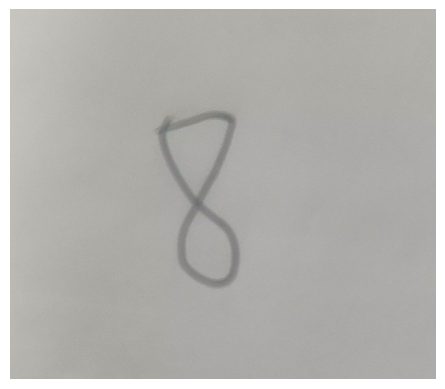

tensor([[ 1.6139,  1.7962,  0.6942, -2.0012, -0.2123, -0.4511, -0.7798,  0.0920,
          0.4188, -0.8260]])
Predicted digit: 1


In [6]:
#展示图片

import matplotlib.pyplot as plt
img = Image.open('./data/8.png')

# 显示图像
plt.imshow(img)
plt.axis('off')  # 可选，关闭坐标轴
plt.show()


# 使用模型进行预测
predicted_digit = predict_image('./data/8.png', model)
print(f"Predicted digit: {predicted_digit}")